In [362]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import mean_squared_error as mse, r2_score as r2


In [363]:
def accuracy(true_values, pred_values, save=False):
      
    print("R2:\t" + str(round(r2(true_values, pred_values), 4)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 4)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 4))
         )

In [364]:
def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [365]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

In [366]:
DATASET_PATH = 'C://users//andrei//DS//train.csv'
DATASET_PATH_test = 'C://users//andrei//DS//test.csv'
mos = pd.read_csv(DATASET_PATH)
test = pd.read_csv(DATASET_PATH_test)
mos.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)
test.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

## Обзор данных

С целью получения общих данных и обработки временно объединим тренировочный и тестовый датасеты.

In [367]:
mos_test = pd.concat([mos, test], axis=0)


In [368]:
mos_test.reset_index(inplace=True)

In [369]:
mos_test.drop(['index'], axis=1, inplace=True)

In [370]:
mos_test.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  15000.000000  15000.000000  15000.000000  15000.000000  11846.000000   
mean    8393.136933     50.693600      1.897000     56.360350     36.851792   
std     4850.111673     43.786257      0.839229     20.423913     71.120183   
min        0.000000      0.000000      0.000000      1.136859      0.333490   
25%     4188.750000     20.000000      1.000000     41.814371     22.896130   
50%     8378.500000     37.000000      2.000000     52.645757     32.822810   
75%    12594.250000     75.000000      2.000000     66.036608     45.144624   
max    16798.000000    212.000000     19.000000    641.065193   7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   15000.000000  15000.000000  15000.000000  1.500000e+04  15000.000000   
mean        6.174467      8.561800     12.606600  3.321575e+03      0.119196   
std        24.016979      5.323113      6.780165  1.637078e+05      0.119371   
min         0.000000      1.000000      0.000000  1.908000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     12.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     78.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1  Healthcare_2  \
count  15000.000000  15000.000000  15000.000000   7825.000000  15000.000000   
mean      24.769267   5370.404933      8.113667   1144.162428      1.319467   
std       17.532278   4013.364403     23.841946   1029.296278      1.489012   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7287.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  15000.000000   10000.000000  
mean       4.235133  214138.857399  
std        4.796545   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

In [371]:
mos_test.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2          Price  
0         0           NaN             0        0       B  305018.871089  
1         1        1183.0             1        0       B  177734.553407  
2         0         240.0             3        1       B  282078.720850  
3         0           NaN             0        1       B  168106.007630  
4         2           NaN             0        6       B  343995.102962

In [372]:
mos_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Healthcare_2   15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_

## Обработка данных

1. Приводим в соответствие число комнат в квартирах
2. Удаляем бессмысленные данные не несущие полезной инормации
3. Меняем выбросы в HouseYear
4. Корректируем столбец Square
5. Нормализуем данные по площади Kitchen
6. Устанавливаем значения комнат по пропускам в стобце Rooms исходя из площади квартир.
7. LifeSquare делаем выборку по нормальным данным. Вычисляем % LifeSqure к Square. Заполняем пропуски "1". Затем вместе
с выбросами вычисляем значения по вычисленному соотношению.
8. В расхождениях этажа и этажности дома уравниваем значения по этажу квартиры.
9. Заполняем нулевые значения в пропусках Ecology_1 берем или моду значения по этому округу или медиану, в случае их отсутствия среднее значение медианы по соседним округам.
10. В полях Ecology_2, Ecology_3 у нас нецифровые значения состоящие только их двух A и B заменим их на 1 и 0 соответственно.

Из года постройки у нас только 2 строки выделяются. Поменяем их на медиану.

In [373]:
condition = (mos_test['HouseYear'] > 2021) | (mos_test['HouseYear'] < 1907)
mos_test[condition]


Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
8828  11607         147    2.0  44.791836   28.360393            5.0      4   
9163  10814         109    1.0  37.265070   20.239714            9.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
8828         9.0       4968   0.319809         B         B        25   
9163        12.0   20052011   0.136330         B         B        30   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
8828      4756        16        2857.0             5        8       B   
9163      6141        10         262.0             3        6       B   

              Price  
8828  243028.603096  
9163  254084.534396

In [374]:
median = mos_test['HouseYear'].median()
mos_test.loc[condition, 'HouseYear'] = median

Выбросы в площади квартир:
1. Вряд ли 1-2 км. квартиры могут иметь площадь более 400 кв. м., смело делим на 10.
2. Площадь 1-2 км. квартир в домах постройки до 1992 тоже не может быть больше 150 кв. м. Прикидочно нужно уменьшить на 100
3. Данные в которых жилая площадь сильно больше общей площади исправим, установим площадь чуть больше жилой. 
4 и 5. Данные с явно ошибочными значениями, трудно представить квартиру с площадью менее 13 - 15 кв. м. 

In [375]:
spam_5 = (mos_test['Square'] < 15)
mos_test[spam_5]


Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
161     6782          45    1.0   2.954309    5.257278            1.0      3   
328     4504          27    3.0   4.390331    5.610772            1.0      8   
1401    9487           5    1.0   5.129222    5.549458            1.0      1   
4496   15744          34    1.0   1.988943    2.642219            1.0     21   
4800    7657          38    1.0   4.502784    4.618547            1.0     28   
5009   11526          27    1.0   4.633498    1.969969            1.0     18   
7033    1748          88    2.0   5.497061   67.628717            1.0     24   
7470   14786           1    1.0   1.136859    4.525736            1.0      3   
8572   10202           6    1.0   2.596351    4.604943            1.0      3   
8805   10527          27    1.0   4.380726   40.805837            1.0     10   
9067   13265           1    3.0   4.823679   79.767964            0.0      6   
9286   12676          81    3.0  13.784865   15.988889            7.0      4   
9869    3224          27    0.0   2.377248    0.873147            0.0      1   
10131  16401          30    1.0   2.645046    4.338755            1.0      2   
10571    170           6    2.0   2.900586   61.468563            1.0     18   
10996   2138          27    1.0   5.647458    1.501582            1.0      1   
11672   1420          45    1.0   1.975769    2.900371            1.0      1   
12051  10120           6    1.0   5.100672    3.861780            1.0      3   
12463   9011          53    1.0   1.378543    1.353573            1.0      1   
13042  15435          21    1.0  13.305531    9.495367            0.0      6   
13166   5480         190    1.0  13.597819   15.948246           12.0      2   
13608   1165          27    1.0   2.372101    1.899119            1.0      2   
14193   7855           6    1.0   4.967143    2.968086            1.0      3   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
161           1.0       1977   0.195781         B         B        23   
328          19.0       2016   0.211401         B         B         9   
1401          1.0       1977   0.150818         B         B        16   
4496          4.0       1977   0.069753         B         B        53   
4800          1.0       1977   0.060753         B         B        15   
5009          1.0       1977   0.011654         B         B         4   
7033         22.0       1977   0.127376         B         B        43   
7470          1.0       1977   0.007122         B         B         1   
8572         25.0       2014   0.243205         B         B         5   
8805         17.0       2013   0.211401         B         B         9   
9067         17.0       1977   0.007122         B         B         1   
9286          5.0       1960   0.319809         B         B        25   
9869          0.0       1977   0.017647         B         B         2   
10131         1.0       1977   0.000078         B         B        22   
10571        17.0       2014   0.243205         B         B         5   
10996         1.0       1977   0.017647         B         B         2   
11672         1.0       1977   0.195781         B         B        23   
12051         1.0       1977   0.243205         B         B         5   
12463         1.0       1977   0.049637         B         B        34   
13042         5.0       1965   0.194489         B         B        47   
13166         5.0       1909   0.000000         B         B        30   
13608        17.0       1977   0.011654         B         B         4   
14193         1.0       2018   0.243205         B         B         5   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
161        5212         6           NaN             3        2       B   
328        1892         0           NaN             0        1       B   
1401       3433         4        2643.0             4        5       B   
4496      13670         4           NaN 

In [376]:
# Уменьшаем отклонения в площади.
spam_1 = (mos_test['Square'] > 400) & (mos_test['Rooms'].between(1, 2))
mos_test.loc[spam_1, 'Square'] = mos_test.loc[spam_1, 'Square'] / 10
spam_2 = (mos_test['Square'] > 150) & (mos_test['Rooms'].between(1, 2)) & (mos_test['HouseYear'] < 1992)
mos_test.loc[spam_2, 'Square'] = mos_test.loc[spam_2, 'Square'] - 100


In [377]:
spam_3 = (mos_test['Square'] < 15) & (mos_test['LifeSquare'] > mos_test['Square'] * 5)
mos_test.loc[spam_3, 'Square'] = mos_test.loc[spam_3, 'LifeSquare'] * 1.2
spam_4 = (mos_test['Square'] < 13) & (mos_test['LifeSquare'] > mos_test['Square'])
mos_test.loc[spam_4, 'Square'] = mos_test.loc[spam_4, 'LifeSquare'] * 12
spam_5 = (mos_test['Square'] < 13)
mos_test.loc[spam_5, 'Square'] = mos_test.loc[spam_5, 'Square'] * 10


In [378]:

# [46.40091176768425, 64.22707042333353, 89.09206449340192, 111.96158300219523]

Теперь значения площади кухни. Вряд ли площадь кухни может превышать 45% общей площади и при этом быть больше 20 кв.м.
Исправим, на 10% от общей площади.

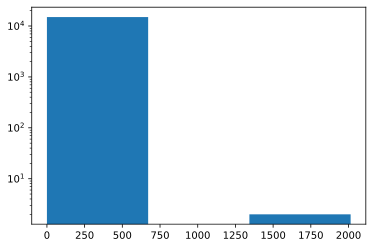

In [379]:
from matplotlib import pyplot as plt
%matplotlib inline
KS = pd.Series(mos_test['KitchenSquare'])
plt.hist(KS, bins=3, log=True)
plt.show()


In [380]:
spam = mos_test[(mos_test['Square']*0.45 < mos_test['KitchenSquare']) & (mos_test['KitchenSquare'] > 20)].index
for el in spam:
    mos_test.loc[el, 'KitchenSquare'] = mos_test.loc[el, 'Square'] * 0.1  
spam

Int64Index([  286,   456,   682,   755,  1728,  2108,  2454,  2702,  2785,
             2831,  3228,  3240,  3586,  3725,  3956,  4091,  5002,  5033,
             5273,  5663,  5695,  5792,  6079,  6293,  6505,  7080,  7601,
             7733,  8329,  8855,  9520, 10337, 10544, 10972, 11224, 12435,
            12557, 13329, 13332, 13750, 14127, 14227, 14342],
           dtype='int64')

In [381]:
mos_test.nlargest(5, 'KitchenSquare')

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
1614    3267          58    3.0  138.980817  138.004600           43.0      2   
2325    7111          27    2.0  139.070296   89.787666           42.0      5   
10683   1968          27    2.0  138.039182   92.484098           42.0      3   
11117   3747          23    5.0  139.045763   89.790274           42.0      1   
12817  13736          27    1.0  141.540215   91.704806           42.0      3   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
1614          2.0       1977   0.437885         B         B        23   
2325          3.0       2016   0.014073         B         B         2   
10683         3.0       2016   0.014073         B         B         2   
11117         3.0       2015   0.014073         B         B         2   
12817         3.0       2013   0.014073         B         B         2   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
1614       5735         3        1084.0             0        5       B   
2325        475         0           NaN             0        0       B   
10683       475         0           NaN             0        0       B   
11117       475         0           NaN             0        0       B   
12817       475         0           NaN             0        0       B   

               Price  
1614   169528.896664  
2325   153946.777452  
10683            NaN  
11117            NaN  
12817            NaN

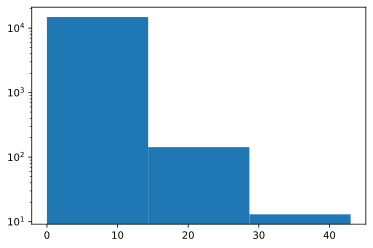

In [382]:
from matplotlib import pyplot as plt
%matplotlib inline
KS = pd.Series(mos_test['KitchenSquare'])
plt.hist(KS, bins=3, log=True)
plt.show()


Теперь большие площади кухни у нас остались в больших квартирах.
Но у нас есть данные, много данных с мизерной площадью кухни.

In [383]:
condition1 = (mos_test['KitchenSquare'] < 4) & (mos_test['Square'] < 40)
condition2 = (mos_test['KitchenSquare'] < 4) & (mos_test['Square'] >= 40)
mos_test[condition2]

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
3       2352           1    1.0  40.409907         NaN            1.0     10   
8       9951           1    1.0  46.887892   44.628132            1.0     12   
9       8094           6    3.0  79.867477   75.085125            1.0      3   
18      4581           1    1.0  47.582480         NaN            1.0     16   
19       367          45    1.0  42.367289   40.012529            1.0     16   
...      ...         ...    ...        ...         ...            ...    ...   
14986  10616           1    2.0  77.463540         NaN            1.0      5   
14988  11890           1    2.0  66.683295         NaN            1.0      6   
14989  13069           1    2.0  61.747208         NaN            0.0      5   
14993  14676           6    1.0  48.435108         NaN            1.0     18   
14994  13060          25    2.0  51.144906   48.979540            1.0     18   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
3            22.0       1977   0.007122         B         B         1   
8            20.0       1977   0.007122         B         B         1   
9            17.0       2014   0.243205         B         B         5   
18           16.0       1977   0.007122         B         B         1   
19           14.0       2015   0.195781         B         B        23   
...           ...        ...        ...       ...       ...       ...   
14986        16.0       2017   0.007122         B         B         1   
14988        17.0       1977   0.007122         B         B         1   
14989        17.0       1977   0.007122         B         B         1   
14993        25.0       1977   0.243205         B         B         5   
14994        25.0       2015   0.069753         B         B        53   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
3           264         0           NaN             0        1       B   
8           264         0           NaN             0        1       B   
9          1564         0         540.0             0        0       B   
18          264         0           NaN             0        1       B   
19         5212         6           NaN             3        2       B   
...         ...       ...           ...           ...      ...     ...   
14986       264         0           NaN             0        1       B   
14988       264         0           NaN             0        1       B   
14989       264         0           NaN             0        1       B   
14993      1564         0         540.0             0        0       B   
14994     13670         4           NaN             1       11       B   

               Price  
3      168106.007630  
8      160400.401732  
9      194756.023945  
18     128803.593810  
19     250466.980777  
...              ...  
14986            NaN  
14988            NaN  
14989            NaN  
14993            NaN  
14994            NaN  

[4176 rows x 20 columns]

Для квартир с небольшой площадью применим стандартное значение кухни
Для квартир площадью > 40 примем значение кухни в 10% от общей площади.

In [384]:
mos_test.loc[condition1, 'KitchenSquare'] = 4
mos_test.loc[condition2, 'KitchenSquare'] = mos_test.loc[condition2, 'Square']*0.1

Количество комнат:
- Сначала приравняем к нулю количество комнат больше 5.
- Затем составим список медиан по площади квартир в зависимости от количества комнат.
- И наконец, заполним данные по нулевым значениям.

In [385]:
mos_test.loc[(mos_test['Rooms'] > 5)]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
2004    5927          57   10.0   59.056975   36.223072      10.000000     22   
2728   14865           9   10.0   60.871266   38.420681      10.000000      3   
6088    8491           1   19.0   42.006046   21.779288       7.000000     17   
8794   14003          99    6.0   59.414334   38.702244       6.000000      7   
10956   4058          27    6.0  223.453689  104.113552      16.000000      2   
11981   1435         111   17.0   52.866107   32.528342       8.000000     15   
12243  10793          23    6.0  110.750226         NaN      11.075023      2   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
2004         22.0       2002   0.090799         B         B        74   
2728          2.0       1994   0.161532         B         B        25   
6088         17.0       2014   0.007122         B         B         1   
8794          9.0       1969   0.033494         B         B        66   
10956         2.0       2017   0.041116         B         B        53   
11981        17.0       1987   0.093443         B         B        23   
12243         2.0       2015   0.014073         B         B         2   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
2004      19083         2           NaN             5       15       B   
2728       5648         1          30.0             2        4       B   
6088        264         0           NaN             0        1       B   
8794      10573         1        1322.0             3        8       B   
10956     14892         4           NaN             1        4       B   
11981      4635         5        3300.0             2        4       B   
12243       475         0           NaN             0        0       B   

               Price  
2004   317265.323792  
2728   172329.270863  
6088    78364.616704  
8794   229661.964416  
10956            NaN  
11981            NaN  
12243            NaN

In [386]:
mos_test.loc[(mos_test['Rooms'] > 5), 'Rooms'] = 0

In [387]:
spam = mos_test.loc[(mos_test['Rooms'] == 0), 'Square'].index
median = []
for el in range(1, 5):
    median.append(mos_test.loc[(mos_test['Rooms'] == el, 'Square')].median() * 1.15)

for el in spam:
    if mos_test.loc[el, 'Square'] > median[3]:
        mos_test.loc[el, 'Rooms'] = 5
    elif mos_test.loc[el, 'Square'] > median[2]:
        mos_test.loc[el, 'Rooms'] = 4
    elif mos_test.loc[el, 'Square'] > median[1]:
        mos_test.loc[el, 'Rooms'] = 3
    elif mos_test.loc[el, 'Square'] > median[0]:
        mos_test.loc[el, 'Rooms'] = 2
    else:
        mos_test.loc[el, 'Rooms'] = 1
    
mos_test['Rooms'].describe()


count    15000.000000
mean         1.895200
std          0.811415
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: Rooms, dtype: float64

In [388]:
median

[46.40091176768425, 64.22707042333353, 89.09206449340192, 111.96158300219523]

Нормализуем жилую площадь по отношению к общей. Для этого вычислим соотношение этих двух площадей по тем данным,
которые выглядят достоверными.

In [389]:
condition = (mos_test['LifeSquare'] < mos_test['Square']) & (mos_test['LifeSquare'] > mos_test['Square']*0.45)
Ratio = mos_test.loc[condition, 'LifeSquare'].mean() / mos_test.loc[condition, 'Square'].mean()
Ratio

0.6515327504971171

In [390]:
mos_test['LifeSquare'] = mos_test['LifeSquare'].fillna(0)
eggs = (mos_test['LifeSquare'] > mos_test['Square']) | (mos_test['LifeSquare'] < mos_test['Square']*0.45)
mos_test.loc[eggs, 'LifeSquare'] = mos_test.loc[eggs, 'Square']*Ratio
# mos_test[eggs]
# mos_test[mos_test['Ecology_1'].isnull()]
# mos_test['Ecology_3'].unique()

In [391]:
mos.loc[mos['LifeSquare'].isnull()]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0     11809          27    3.0  115.027311         NaN           10.0      4   
3      2352           1    1.0   40.409907         NaN            1.0     10   
18     4581           1    1.0   47.582480         NaN            1.0     16   
20     8768          63    1.0   50.974891         NaN            1.0      7   
24     4717          27    1.0   44.203947         NaN            0.0      2   
...     ...         ...    ...         ...         ...            ...    ...   
9975   4944           6    2.0   52.573133         NaN            1.0     18   
9978   4851           1    1.0   39.314342         NaN            1.0     13   
9981   6753          62    2.0   73.092686         NaN            1.0      4   
9983    647           1    2.0   63.324025         NaN            1.0      4   
9991  11173           6    2.0   62.648779         NaN            0.0      6   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
0           10.0       2014   0.075424         B         B        11   
3           22.0       1977   0.007122         B         B         1   
18          16.0       1977   0.007122         B         B         1   
20          16.0       2018   0.238617         B         B        26   
24           0.0       1977   0.072158         B         B         2   
...          ...        ...        ...       ...       ...       ...   
9975        17.0       1977   0.243205         B         B         5   
9978        17.0       1977   0.007122         B         B         1   
9981        16.0       2017   0.072158         B         B         2   
9983        17.0       1977   0.007122         B         B         1   
9991        17.0       1977   0.243205         B         B         5   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
0         3097         0           NaN             0        0       B   
3          264         0           NaN             0        1       B   
18         264         0           NaN             0        1       B   
20        3889         6         705.0             3        6       B   
24         629         1           NaN             0        0       A   
...        ...       ...           ...           ...      ...     ...   
9975      1564         0         540.0             0        0       B   
9978       264         0           NaN             0        1       B   
9981       629         1           NaN             0        0       A   
9983       264         0           NaN             0        1       B   
9991      1564         0         540.0             0        0       B   

              Price  
0     305018.871089  
3     168106.007630  
18    128803.593810  
20    260328.413376  
24    135466.559958  
...             ...  
9975  154366.031184  
9978  137782.941940  
9981  159077.198056  
9983  183809.327114  
9991  182625.548872  

[2113 rows x 20 columns]

In [392]:
mos_test.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    8393.136933     50.693600      1.895200     56.292609     36.676478   
std     4850.111673     43.786257      0.811415     18.942265     14.561120   
min        0.000000      0.000000      1.000000     13.305531      8.822988   
25%     4188.750000     20.000000      1.000000     41.843411     26.064493   
50%     8378.500000     37.000000      2.000000     52.689236     33.585826   
75%    12594.250000     75.000000      2.000000     66.033028     44.510907   
max    16798.000000    212.000000      5.000000    275.645284    233.949309   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean        7.376260      8.561800     12.606600   1984.706733      0.119196   
std         2.572473      5.323113      6.780165     18.465246      0.119371   
min         4.000000      1.000000      0.000000   1908.000000      0.000000   
25%         5.187037      4.000000      9.000000   1974.000000      0.017647   
50%         7.000000      7.000000     12.000000   1977.000000      0.075424   
75%         9.000000     12.000000     17.000000   2001.000000      0.195781   
max        43.000000     78.000000    117.000000   2020.000000      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1  Healthcare_2  \
count  15000.000000  15000.000000  15000.000000   7825.000000  15000.000000   
mean      24.769267   5370.404933      8.113667   1144.162428      1.319467   
std       17.532278   4013.364403     23.841946   1029.296278      1.489012   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7287.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  15000.000000   10000.000000  
mean       4.235133  214138.857399  
std        4.796545   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

In [393]:
mos_test['LifeSquare'].isna().sum()

0

In [394]:
mos_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     15000 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Healthcare_2   15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_

In [395]:
condition = (mos_test['Floor'] > mos_test['HouseFloor'])
mos_test.loc[condition, 'HouseFloor'] = mos_test.loc[condition, 'Floor']
mos_test[condition]


Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
17      1190           8    2.0  49.396000   28.299600       5.000000      6   
19       367          45    1.0  42.367289   40.012529       4.236729     16   
21      8471          20    3.0  75.611065   47.494621       8.000000     11   
24      4717          27    1.0  44.203947   28.800319       4.420395      2   
25      4521           6    2.0  65.409965   42.616735       6.540997     18   
...      ...         ...    ...        ...         ...            ...    ...   
14976  14793          27    1.0  47.295978   45.000047      10.000000      6   
14978  15243          53    2.0  56.872925   37.054574       5.687293     20   
14980  11709          63    1.0  51.872447   33.796598       5.187245     23   
14982   8197           9    1.0  38.595211   22.895884       8.000000     19   
14995  10379          29    2.0  43.177521   30.339945       5.000000      6   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
17            6.0       1962   0.458174         B         A        26   
19           16.0       2015   0.195781         B         B        23   
21           11.0       1976   0.019509         B         B        37   
24            2.0       1977   0.072158         B         B         2   
25           18.0       1977   0.243205         B         B         5   
...           ...        ...        ...       ...       ...       ...   
14976         6.0       2017   0.072158         B         B         2   
14978        20.0       1977   0.049637         B         B        34   
14980        23.0       2016   0.238617         B         B        26   
14982        19.0       1992   0.161532         B         B        25   
14995         6.0       1962   0.069660         B         B        31   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
17         4439         1        1130.0             1        5       B   
19         5212         6           NaN             3        2       B   
21         7687        11         176.0             5        5       B   
24          629         1           NaN             0        0       A   
25         1564         0         540.0             0        0       B   
...         ...       ...           ...           ...      ...     ...   
14976       629         1           NaN             0        0       A   
14978      7759         0         229.0             1        3       B   
14980      3889         6         705.0             3        6       B   
14982      5648         1          30.0             2        4       B   
14995      6119         4           NaN             1        2       B   

               Price  
17     186971.926566  
19     250466.980777  
21     366916.246494  
24     135466.559958  
25     191205.272608  
...              ...  
14976            NaN  
14978            NaN  
14980            NaN  
14982            NaN  
14995            NaN  

[2709 rows x 20 columns]

In [396]:
eggs =(mos_test['Ecology_1'] == 0)
mos_test[eggs]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
22      1550           7    3.0   86.326360   46.097241           10.0      3   
51     12774         157    2.0   62.747509   40.882057            8.0      5   
98      7028         111    2.0   54.392900   30.792077            8.0     15   
105     9544          46    1.0   36.136757   21.140934            5.0      3   
121    16102          17    1.0   38.595782   19.418504           10.0     14   
...      ...         ...    ...         ...         ...            ...    ...   
14894  15180          31    2.0   62.626215   39.782345            8.0      8   
14895   8948          18    1.0   42.217038   21.758672            8.0      2   
14925   8227          46    1.0   44.411051   28.359856            5.0      5   
14940  14486         123    2.0   85.997697   45.553089           12.0     10   
14965  16228          17    1.0  121.453559   87.521642           17.0     17   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
22           17.0       1986        0.0         B         B        23   
51           10.0       1956        0.0         B         B        30   
98           17.0       1990        0.0         B         B        36   
105           5.0       1968        0.0         B         B        47   
121          14.0       1966        0.0         B         B        18   
...           ...        ...        ...       ...       ...       ...   
14894         9.0       1960        0.0         B         B        23   
14895        17.0       1996        0.0         B         B        30   
14925         5.0       1965        0.0         B         B        47   
14940        18.0       2008        0.0         B         B         6   
14965        22.0       2013        0.0         B         B        18   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
22         5067         4           NaN             2        6       B   
51         7538        87        4702.0             5        5       B   
98         6714         2        2672.0             0        2       B   
105       11319         0        1145.0             3        5       B   
121        3374         5         620.0             1        2       B   
...         ...       ...           ...           ...      ...     ...   
14894      3684         2           NaN             0        4       B   
14895      5562         0           NaN             0        5       A   
14925     11319         0        1145.0             3        5       B   
14940      2733         0         920.0             0        4       B   
14965      3374         5         620.0             1        2       B   

               Price  
22     421803.748753  
51     555661.943969  
98     214439.612368  
105    173393.070968  
121    202533.970644  
...              ...  
14894            NaN  
14895            NaN  
14925            NaN  
14940            NaN  
14965            NaN  

[816 rows x 20 columns]

В столбце 'Ecology_1' много пропущенных данных. Сделаем допущение что значение этого параметра в одном округе примерно
одинаково.
Составим список округов и занесем данные в словарь по следующему принципу:
- в первую очередь вносим наиболее часто встречающееся значение;
- во вторую очередь среднее значение по этому округу;
- если по этому округу нет никаких данных внесем среднее значение составленное из значений по соседним округам.


In [397]:
sample = sorted(mos_test['DistrictId'].unique())
ecology = dict()
for n, el in enumerate(sample):
    eggs = mos_test.loc[(mos_test['DistrictId'] == el), 'Ecology_1'].mode()[0]
    if eggs == 0:
        eggs = mos_test.loc[(mos_test['DistrictId'] == el), 'Ecology_1'].median()
    if eggs == 0 and n < len(sample) - 1:
        eggs = (mos_test.loc[(mos_test['DistrictId'] == sample[n - 1]), 'Ecology_1'].median() + mos_test.loc[(mos_test['DistrictId'] == sample[n + 1]), 'Ecology_1'].median()) / 2
    else:
        eggs = (mos_test.loc[(mos_test['DistrictId'] == sample[n - 1]), 'Ecology_1'].median() + mos_test.loc[(mos_test['DistrictId'] == sample[0]), 'Ecology_1'].median()) / 2

    ecology[el] = eggs 

Теперь используя составленный словарь внесем данные по тем строкам где это значение отсутствует.

In [398]:
eggs =(mos_test['Ecology_1'] == 0)
zero = pd.Series(mos_test.loc[eggs, 'DistrictId'])
for k, v  in zip(zero.index, zero.values):
    mos_test.loc[k, 'Ecology_1'] = ecology[v] 
mos_test[eggs]

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
22      1550           7    3.0   86.326360   46.097241           10.0      3   
51     12774         157    2.0   62.747509   40.882057            8.0      5   
98      7028         111    2.0   54.392900   30.792077            8.0     15   
105     9544          46    1.0   36.136757   21.140934            5.0      3   
121    16102          17    1.0   38.595782   19.418504           10.0     14   
...      ...         ...    ...         ...         ...            ...    ...   
14894  15180          31    2.0   62.626215   39.782345            8.0      8   
14895   8948          18    1.0   42.217038   21.758672            8.0      2   
14925   8227          46    1.0   44.411051   28.359856            5.0      5   
14940  14486         123    2.0   85.997697   45.553089           12.0     10   
14965  16228          17    1.0  121.453559   87.521642           17.0     17   

       HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
22           17.0       1986   0.281507         B         B        23   
51           10.0       1956   0.014337         B         B        30   
98           17.0       1990   0.176652         B         B        36   
105           5.0       1968   0.148827         B         B        47   
121          14.0       1966   0.018589         B         B        18   
...           ...        ...        ...       ...       ...       ...   
14894         9.0       1960   0.159944         B         B        23   
14895        17.0       1996   0.154740         B         B        30   
14925         5.0       1965   0.148827         B         B        47   
14940        18.0       2008   0.101292         B         B         6   
14965        22.0       2013   0.018589         B         B        18   

       Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1 Shops_2  \
22         5067         4           NaN             2        6       B   
51         7538        87        4702.0             5        5       B   
98         6714         2        2672.0             0        2       B   
105       11319         0        1145.0             3        5       B   
121        3374         5         620.0             1        2       B   
...         ...       ...           ...           ...      ...     ...   
14894      3684         2           NaN             0        4       B   
14895      5562         0           NaN             0        5       A   
14925     11319         0        1145.0             3        5       B   
14940      2733         0         920.0             0        4       B   
14965      3374         5         620.0             1        2       B   

               Price  
22     421803.748753  
51     555661.943969  
98     214439.612368  
105    173393.070968  
121    202533.970644  
...              ...  
14894            NaN  
14895            NaN  
14925            NaN  
14940            NaN  
14965            NaN  

[816 rows x 20 columns]

In [399]:
mos['Ecology_2'].unique(), mos['Ecology_3'].unique()

(array(['B', 'A'], dtype=object), array(['B', 'A'], dtype=object))

В столбцах 'Ecology_2' и 'Ecology_3' заменим буквенные значения на 0 и 1.
Для этого составим функцию.

In [400]:
def to_bin(*args):
    
    # меняет значения b = 0, a = 1
    for el in args:
        mos_test.loc[(mos_test[el] == 'B'), el] = 0
        mos_test.loc[(mos_test[el] == 'A'), el] = 1
        mos_test[el] = mos_test[el].astype(np.int8)
        

In [401]:
to_bin('Ecology_2', 'Ecology_3')


In [402]:
mos_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     15000 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  int8   
 11  Ecology_3      15000 non-null  int8   
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Healthcare_2   15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_

In [403]:
mos_test.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    8393.136933     50.693600      1.895200     56.292609     36.676478   
std     4850.111673     43.786257      0.811415     18.942265     14.561120   
min        0.000000      0.000000      1.000000     13.305531      8.822988   
25%     4188.750000     20.000000      1.000000     41.843411     26.064493   
50%     8378.500000     37.000000      2.000000     52.689236     33.585826   
75%    12594.250000     75.000000      2.000000     66.033028     44.510907   
max    16798.000000    212.000000      5.000000    275.645284    233.949309   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   15000.000000  15000.000000  15000.000000  15000.000000  1.500000e+04   
mean        7.376260      8.561800     13.422133   1984.706733  1.269861e-01   
std         2.572473      5.323113      6.140156     18.465246  1.177167e-01   
min         4.000000      1.000000      1.000000   1908.000000  1.800000e-09   
25%         5.187037      4.000000      9.000000   1974.000000  3.465608e-02   
50%         7.000000      7.000000     14.000000   1977.000000  8.688527e-02   
75%         9.000000     12.000000     17.000000   2001.000000  2.104732e-01   
max        43.000000     78.000000    117.000000   2020.000000  5.218671e-01   

          Ecology_2     Ecology_3      Social_1      Social_2      Social_3  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean       0.009667      0.028267     24.769267   5370.404933      8.113667   
std        0.097846      0.165739     17.532278   4013.364403     23.841946   
min        0.000000      0.000000      0.000000    168.000000      0.000000   
25%        0.000000      0.000000      6.000000   1564.000000      0.000000   
50%        0.000000      0.000000     25.000000   5285.000000      2.000000   
75%        0.000000      0.000000     36.000000   7287.000000      5.000000   
max        1.000000      1.000000     74.000000  19083.000000    141.000000   

       Healthcare_1  Healthcare_2       Shops_1          Price  
count   7825.000000  15000.000000  15000.000000   10000.000000  
mean    1144.162428      1.319467      4.235133  214138.857399  
std     1029.296278      1.489012      4.796545   92872.293865  
min        0.000000      0.000000      0.000000   59174.778028  
25%      350.000000      0.000000      1.000000  153872.633942  
50%      900.000000      1.000000      3.000000  192269.644879  
75%     1548.000000      2.000000      6.000000  249135.462171  
max     4849.000000      6.000000     23.000000  633233.466570

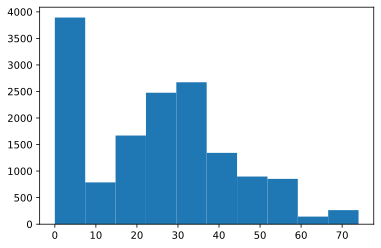

In [404]:
KS = pd.Series(mos_test['Social_1'])
plt.hist(KS, bins=10)
plt.show()

Значение 'Social_1' кажется распределенно неравномерно. Однако если составить распределение в среднем по каждому округу, 
то распределение уже выглядит более нормально. Неравномерно выглядит рапределение 'Social_3', но не будем изменять этот показатель. Если под понятием 'Social_3' скрывается количество театров и музеев то ошибочно распределять этот показатель по всем округам равномерно. 

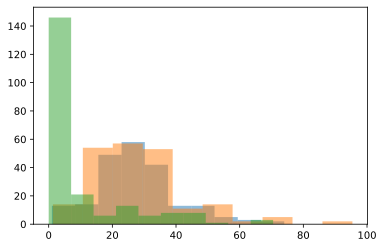

In [405]:
%config InlineBackend.figure_format = 'svg'
sample = sorted(mos_test['DistrictId'].unique())
S1 = dict()
S2 = dict()
S3 = dict()
for el in sample:
    S1[el] = mos_test.loc[(mos_test['DistrictId'] == el), 'Social_1'].median()
    S2[el] = mos_test.loc[(mos_test['DistrictId'] == el), 'Social_2'].median()/200
    S3[el] = mos_test.loc[(mos_test['DistrictId'] == el), 'Social_3'].median()/2
S1 = pd.Series(S1)
S2 = pd.Series(S2)
S3 = pd.Series(S3)
plt.hist(S1, bins=10, alpha=0.5)
plt.hist(S2, bins=10, alpha=0.5)
plt.hist(S3, bins=10, alpha=0.5)
plt.show()

In [406]:
mos[['Social_1', 'Social_2', 'Social_3']].isna().sum()

Social_1    0
Social_2    0
Social_3    0
dtype: int64

Переходим к показателю 'Healthcare_1', здесь у нас много пропущенных данных. Но медицина должна присутствовать во всех округах, так что попробуем заполнить эти данные. Сначала заполним отсутствующие данные 0.
Затем составим словарь в который занесем данные по округам.
По тем округам где есть данные заполним словарь средним значением, по тем же где их нет заполним случайным образом.

In [407]:
mos_test = mos_test.fillna({'Healthcare_1': 0, 'LifeSquare': 0})

In [408]:
health = dict()
for el in sample:
    # temp = mos.loc[(mos['DistrictId'] == el) & (mos['Healthcare_1'].notnull()), 'Healthcare_1'].mean()
    temp = mos_test.loc[(mos_test['DistrictId'] == el), 'Healthcare_1'].mean()
    if temp == 0:
        temp = np.random.randint(0, 4849, 1)[0]
    health[el] = temp

In [409]:
zero = pd.Series(mos_test.loc[(mos_test['Healthcare_1'] == 0), 'DistrictId'])
for k, v in zip(zero.index, zero.values):
    mos_test.loc[k, 'Healthcare_1'] = health[v]

In [410]:
spam = (mos_test['Healthcare_1'] == 0)
mos_test[spam]

Empty DataFrame
Columns: [Id, DistrictId, Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Healthcare_2, Shops_1, Shops_2, Price]
Index: []

In [411]:
S1 = dict()
for el in sample:
    S1[el] = mos.loc[(mos['DistrictId'] == el), 'Healthcare_2'].median()
S1 = pd.Series(S1)

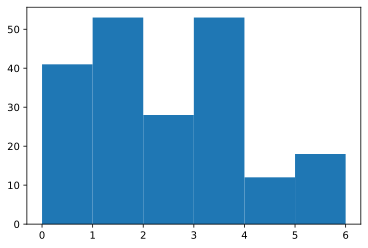

In [412]:
plt.hist(S1, bins=6)
plt.show()

Показатель 'Healthcare_2' выглядит нормально, не будем его изменять.
Заменим на числовый данные показатель 'Shops_2'.

In [413]:
mos_test['Shops_2'].unique()

array(['B', 'A'], dtype=object)

In [414]:
to_bin('Shops_2')


Поменяем тип данных для некоторых показателей параметры явно избыточные.

In [415]:
mos_test[['Rooms', 'Shops_1', 'Shops_2', 'Ecology_2', 'Ecology_3', 'Healthcare_2']] = \
    mos_test[['Rooms', 'Shops_1', 'Shops_2', 'Ecology_2', 'Ecology_3', 'Healthcare_2']].astype(np.int8)
mos_test[['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1']] = \
    mos_test[['DistrictId', 'Floor', 'HouseFloor', 'HouseYear', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1']].astype(np.int16)
mos_test[['Square', 'LifeSquare', 'KitchenSquare', 'Ecology_1', 'Price']] = \
    mos_test[['Square', 'LifeSquare', 'KitchenSquare', 'Ecology_1', 'Price']].astype(np.float32)

In [416]:
mos_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int16  
 2   Rooms          15000 non-null  int8   
 3   Square         15000 non-null  float32
 4   LifeSquare     15000 non-null  float32
 5   KitchenSquare  15000 non-null  float32
 6   Floor          15000 non-null  int16  
 7   HouseFloor     15000 non-null  int16  
 8   HouseYear      15000 non-null  int16  
 9   Ecology_1      15000 non-null  float32
 10  Ecology_2      15000 non-null  int8   
 11  Ecology_3      15000 non-null  int8   
 12  Social_1       15000 non-null  int16  
 13  Social_2       15000 non-null  int16  
 14  Social_3       15000 non-null  int16  
 15  Healthcare_1   15000 non-null  int16  
 16  Healthcare_2   15000 non-null  int8   
 17  Shops_1        15000 non-null  int8   
 18  Shops_

In [417]:
mos_test.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    8393.136933     50.693600      1.895200     56.292824     36.676479   
std     4850.111673     43.786257      0.811415     18.942257     14.561110   
min        0.000000      0.000000      1.000000     13.305532      8.822989   
25%     4188.750000     20.000000      1.000000     41.843411     26.064492   
50%     8378.500000     37.000000      2.000000     52.689238     33.585827   
75%    12594.250000     75.000000      2.000000     66.033026     44.510907   
max    16798.000000    212.000000      5.000000    275.645294    233.949310   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   15000.000000  15000.000000  15000.000000  15000.000000  1.500000e+04   
mean        7.376258      8.561800     13.422133   1984.706733  1.269844e-01   
std         2.572463      5.323113      6.140156     18.465246  1.177168e-01   
min         4.000000      1.000000      1.000000   1908.000000  1.800000e-09   
25%         5.187037      4.000000      9.000000   1974.000000  3.465608e-02   
50%         7.000000      7.000000     14.000000   1977.000000  8.688527e-02   
75%         9.000000     12.000000     17.000000   2001.000000  2.104732e-01   
max        43.000000     78.000000    117.000000   2020.000000  5.218670e-01   

          Ecology_2     Ecology_3      Social_1      Social_2      Social_3  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean       0.009667      0.028267     24.769267   5370.404933      8.113667   
std        0.097846      0.165739     17.532278   4013.364403     23.841946   
min        0.000000      0.000000      0.000000    168.000000      0.000000   
25%        0.000000      0.000000      6.000000   1564.000000      0.000000   
50%        0.000000      0.000000     25.000000   5285.000000      2.000000   
75%        0.000000      0.000000     36.000000   7287.000000      5.000000   
max        1.000000      1.000000     74.000000  19083.000000    141.000000   

       Healthcare_1  Healthcare_2       Shops_1       Shops_2          Price  
count  15000.000000  15000.000000  15000.000000  15000.000000   10000.000000  
mean    1258.109400      1.319467      4.235133      0.082467  214138.937500  
std     1286.672967      1.489012      4.796545      0.275084   92872.273438  
min        3.000000      0.000000      0.000000      0.000000   59174.777344  
25%      225.000000      0.000000      1.000000      0.000000  153872.625000  
50%      750.000000      1.000000      3.000000      0.000000  192269.656250  
75%     1994.000000      2.000000      6.000000      0.000000  249135.468750  
max     4849.000000      6.000000     23.000000      1.000000  633233.437500

In [418]:
mos_test['TruePrice'] = mos_test['Price'] / mos_test['Square']
averageDP = mos_test.groupby('DistrictId').agg({'TruePrice': 'median'})
median_p = mos_test['TruePrice'].mean()
averageDP['TruePrice'].fillna(median_p, inplace=True)
mos_test.drop('TruePrice', axis=1, inplace=True)

In [419]:
mos_test = pd.merge(mos_test, averageDP, on='DistrictId', how='left')
mos_test.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean    8393.136933     50.693600      1.895200     56.292824     36.676479   
std     4850.111673     43.786257      0.811415     18.942257     14.561110   
min        0.000000      0.000000      1.000000     13.305532      8.822989   
25%     4188.750000     20.000000      1.000000     41.843411     26.064492   
50%     8378.500000     37.000000      2.000000     52.689238     33.585827   
75%    12594.250000     75.000000      2.000000     66.033026     44.510907   
max    16798.000000    212.000000      5.000000    275.645294    233.949310   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   15000.000000  15000.000000  15000.000000  15000.000000  1.500000e+04   
mean        7.376258      8.561800     13.422133   1984.706733  1.269844e-01   
std         2.572463      5.323113      6.140156     18.465246  1.177168e-01   
min         4.000000      1.000000      1.000000   1908.000000  1.800000e-09   
25%         5.187037      4.000000      9.000000   1974.000000  3.465608e-02   
50%         7.000000      7.000000     14.000000   1977.000000  8.688527e-02   
75%         9.000000     12.000000     17.000000   2001.000000  2.104732e-01   
max        43.000000     78.000000    117.000000   2020.000000  5.218670e-01   

       ...     Ecology_3      Social_1      Social_2      Social_3  \
count  ...  15000.000000  15000.000000  15000.000000  15000.000000   
mean   ...      0.028267     24.769267   5370.404933      8.113667   
std    ...      0.165739     17.532278   4013.364403     23.841946   
min    ...      0.000000      0.000000    168.000000      0.000000   
25%    ...      0.000000      6.000000   1564.000000      0.000000   
50%    ...      0.000000     25.000000   5285.000000      2.000000   
75%    ...      0.000000     36.000000   7287.000000      5.000000   
max    ...      1.000000     74.000000  19083.000000    141.000000   

       Healthcare_1  Healthcare_2       Shops_1       Shops_2          Price  \
count  15000.000000  15000.000000  15000.000000  15000.000000   10000.000000   
mean    1258.109400      1.319467      4.235133      0.082467  214138.937500   
std     1286.672967      1.489012      4.796545      0.275084   92872.273438   
min        3.000000      0.000000      0.000000      0.000000   59174.777344   
25%      225.000000      0.000000      1.000000      0.000000  153872.625000   
50%      750.000000      1.000000      3.000000      0.000000  192269.656250   
75%     1994.000000      2.000000      6.000000      0.000000  249135.468750   
max     4849.000000      6.000000     23.000000      1.000000  633233.437500   

          TruePrice  
count  15000.000000  
mean    3933.881348  
std      992.977539  
min     2280.972900  
25%     2938.048340  
50%     4134.353516  
75%     4562.026367  
max     8700.768555  

[8 rows x 21 columns]

Делаем единую функцию для подготовки данных.

In [420]:
def data_prep(data):
        
    def to_bin(*args):
        # меняет значения b = 0, a = 1
        for el in args:
            data.loc[(data[el] == 'B'), el] = 0
            data.loc[(data[el] == 'A'), el] = 1
            data[el] = data[el].astype(np.int8)
    # Функция для подстановки значений из словарей
    def data_insert(select, column, data_dict):
        zero = pd.Series(data.loc[select, 'DistrictId'])
        for k, v in zip(zero.index, zero.values):
            data.loc[k, column] = data_dict[v]
    
    # Данные для заполнения
    house_median = 1977
    list_rsm = [46.40091176768425, 64.22707042333353, 89.09206449340192, 111.96158300219523]
    ratio_lifesquare = 0.6515448207532145
    # Также будем использовать словари ecology и health таблицу averageDP
    
     # Нормализация года постройки
    spam_0 = (data['HouseYear'] > 2021) | (data['HouseYear'] < 1907) # Отклонения в годе постройки
    data.loc[spam_0, 'HouseYear'] = house_median
    
    # Заполняем отсутствующие данные
    data = data.fillna({'Healthcare_1': 0, 'LifeSquare': 1})
    
    # Нормализация общей площади - 'Square'
    spam_1 = (data['Square'] > 400) & (data['Rooms'].between(1, 2))
    data.loc[spam_1, 'Square'] = data.loc[spam_1, 'Square'] / 15
    spam_2 = (data['Square'] > 150) & (data['Rooms'].between(1, 2)) & (data['HouseYear'] < 1992)
    data.loc[spam_2, 'Square'] = data.loc[spam_2, 'Square'] /3
    spam_3 = (data['Square'] < 15) & (data['LifeSquare'] > data['Square'] * 5)
    data.loc[spam_3, 'Square'] = data.loc[spam_3, 'LifeSquare'] * 1.2
    spam_4 = (data['Square'] < 13) & (data['LifeSquare'] > data['Square'])
    data.loc[spam_4, 'Square'] = data.loc[spam_4, 'LifeSquare'] * 12
    spam_5 = (data['Square'] < 13)
    data.loc[spam_5, 'Square'] = data.loc[spam_5, 'Square'] * 12
#     spam_14 = (data['Price'] / data['Square'] < 1000)
#     data.loc[spam_14, 'Square'] = data.loc[spam_14, 'LifeSquare'] * 1.2
    
    # Нормализация площади кухни
    spam_6 = data[(data['Square']*0.45 < data['KitchenSquare']) & (data['KitchenSquare'] > 20)].index
    for el in spam_6:
        data.loc[el, 'KitchenSquare'] = data.loc[el, 'Square'] * 0.1 
    
    spam_7 = (data['KitchenSquare'] < 4) & (data['Square'] < 40)
    spam_8 = (data['KitchenSquare'] < 4) & (data['Square'] >= 40)
    data.loc[spam_7, 'KitchenSquare'] = 6 # Пр. значение 4
    data.loc[spam_8, 'KitchenSquare'] = data.loc[spam_8, 'Square']*0.12 # Предыдущее значение 0.1
    
    # Заполнение 0 значений в поле количество комнат
    data.loc[(data['Rooms'] > 5), 'Rooms'] = 0
    spam_9 = data.loc[(data['Rooms'] == 0), 'Square'].index
    for el in spam_9:
        if data.loc[el, 'Square'] > list_rsm[3]:
            data.loc[el, 'Rooms'] = 5
        elif data.loc[el, 'Square'] > list_rsm[2]:
            data.loc[el, 'Rooms'] = 4
        elif data.loc[el, 'Square'] > list_rsm[1]:
            data.loc[el, 'Rooms'] = 3
        elif data.loc[el, 'Square'] > list_rsm[0]:
            data.loc[el, 'Rooms'] = 2
        else:
            data.loc[el, 'Rooms'] = 1
    
    # Заполнение пропущенных значений жилой площади
    spam_10 = (data['LifeSquare'] > data['Square']) | (data['LifeSquare'] < data['Square']*0.45)
    data.loc[spam_10, 'LifeSquare'] = data.loc[spam_10, 'Square'] * ratio_lifesquare
    
    # Нормализация расхождений в этажности
    spam_11 = (data['Floor'] > data['HouseFloor'])
    data.loc[spam_11, 'HouseFloor'] = data.loc[spam_11, 'Floor'] + 1 #Пр. значение было без добавления.
    
    # Заполнение пропущенных значений в поле 'Ecology_1'.
    spam_12 =(data['Ecology_1'] == 0)
    
    data_insert(spam_12, 'Ecology_1', ecology)
            
    # Заполняем пропущенные значения в поле Healthcare_1
    spam_13 =(data['Healthcare_1'] == 0)

    data_insert(spam_13, 'Healthcare_1', health)
    
    # Меняем значения на цифровые в полях Ecology_2, Ecology_3, Shops_2
    to_bin('Ecology_2', 'Ecology_3', 'Shops_2')
    
    # Добавляем столбец цена за 1 кв.м по району.
    data = pd.merge(data, averageDP, on='DistrictId', how='left')
    
    return data

## Анализ признаков, отбор признаков.

In [452]:
mos = pd.read_csv(DATASET_PATH)
test = pd.read_csv(DATASET_PATH_test)
mos.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)
test.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

In [422]:
mos = data_prep(mos)
mos.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.888800     56.182619     36.618252   
std     4859.01902     43.587592      0.812589     18.946465     14.675769   
min        0.00000      0.000000      1.000000     13.784865      8.822988   
25%     4169.50000     20.000000      1.000000     41.784790     26.034847   
50%     8394.50000     36.000000      2.000000     52.539909     33.452635   
75%    12592.50000     75.000000      2.000000     65.889736     44.404930   
max    16798.00000    209.000000      5.000000    275.645284    233.949309   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  1.000000e+04   
mean        7.811859      8.526700     13.618200   1984.863800  1.264915e-01   
std         2.492094      5.241148      6.024306     18.409979  1.173824e-01   
min         4.000000      1.000000      1.000000   1910.000000  1.800000e-09   
25%         6.000000      4.000000      9.000000   1974.000000  3.465608e-02   
50%         7.859210      7.000000     14.000000   1977.000000  8.688527e-02   
75%         9.000000     12.000000     17.000000   2001.000000  2.001468e-01   
max        43.000000     42.000000    117.000000   2020.000000  5.218671e-01   

       ...     Ecology_3      Social_1      Social_2      Social_3  \
count  ...  10000.000000  10000.000000  10000.000000  10000.000000   
mean   ...      0.027500     24.687000   5352.157400      8.039200   
std    ...      0.163543     17.532614   4006.799803     23.831875   
min    ...      0.000000      0.000000    168.000000      0.000000   
25%    ...      0.000000      6.000000   1564.000000      0.000000   
50%    ...      0.000000     25.000000   5285.000000      2.000000   
75%    ...      0.000000     36.000000   7227.000000      5.000000   
max    ...      1.000000     74.000000  19083.000000    141.000000   

       Healthcare_1  Healthcare_2       Shops_1       Shops_2          Price  \
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    1265.353852      1.319500      4.231300      0.082500  214138.857399   
std     1287.997747      1.493601      4.806341      0.275139   92872.293865   
min        3.516484      0.000000      0.000000      0.000000   59174.778028   
25%      229.000000      0.000000      1.000000      0.000000  153872.633942   
50%      750.000000      1.000000      3.000000      0.000000  192269.644879   
75%     2035.525641      2.000000      6.000000      0.000000  249135.462171   
max     4849.000000      6.000000     23.000000      1.000000  633233.466570   

          TruePrice  
count  10000.000000  
mean    3927.821533  
std      997.087952  
min     2280.972900  
25%     2938.048340  
50%     4134.353516  
75%     4562.026367  
max     8700.768555  

[8 rows x 21 columns]

In [423]:
mos.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311   74.945448      10.000000      4   
1   3013          22    1.0   39.832524   23.169223       8.000000      7   
2   8215           1    3.0   78.342215   47.671972      10.000000      2   
3   2352           1    1.0   40.409907   26.328866       4.849189     10   
4  13866          94    2.0   64.285067   38.562517       9.000000     16   

   HouseFloor  HouseYear  Ecology_1  ...  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424  ...          0        11      3097   
1         8.0       1966   0.118537  ...          0        30      6207   
2        17.0       1988   0.025609  ...          0        33      5261   
3        22.0       1977   0.007122  ...          0         1       264   
4        16.0       1972   0.282798  ...          0        33      8667   

   Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2          Price  \
0         0   3125.000000             0        0        0  305018.871089   
1         1   1183.000000             1        0        0  177734.553407   
2         0    240.000000             3        1        0  282078.720850   
3         0     21.967871             0        1        0  168106.007630   
4         2   1041.000000             0        6        0  343995.102962   

     TruePrice  
0  2759.086182  
1  3553.678467  
2  3251.202393  
3  3251.202393  
4  4219.992676  

[5 rows x 21 columns]

In [424]:
mos.to_csv("mos_p.csv", sep=",", index=False)

In [473]:
test.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698122   61.048526           10.0     21   
4997   3912         101    1.0  33.656723   19.003259            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
4995         7.0       1962   0.069660          0          0        31   
4996        27.0       2018   0.060753          0          0        15   
4997         5.0       1966   0.038693          0          0        28   
4998        14.0       1970   0.089040          0          0        33   
4999        17.0       2009   0.194489          0          0        47   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2  \
4995      6119         4    528.228188             1        2        0   
4996      2787         2    520.000000             0        7        0   
4997      6533         1   1015.000000             2        5        0   
4998      7976         5   3909.000000             0       11        0   
4999      8004         3    125.000000             3        5        0   

        TruePrice  
4995  4186.662598  
4996  4665.583008  
4997  4188.414551  
4998  4458.893555  
4999  3986.568115

In [453]:
test = data_prep(test)
colnames = test.columns
test.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean    8412.595400    51.279200     1.908000    56.501171    36.786137   
std     4832.674037    44.179466     0.808991    18.931474    14.328752   
min        1.000000     0.000000     1.000000    13.305531     8.859588   
25%     4221.750000    21.000000     1.000000    41.926034    26.135399   
50%     8320.500000    37.000000     2.000000    52.957761    33.795940   
75%    12598.250000    77.000000     2.000000    66.289167    44.725167   
max    16795.000000   212.000000     5.000000   223.453689   136.921090   

       KitchenSquare        Floor   HouseFloor    HouseYear     Ecology_1  \
count    5000.000000  5000.000000  5000.000000  5000.000000  5.000000e+03   
mean        7.782875     8.632000    13.571800  1984.392600  1.279752e-01   
std         2.498090     5.483228     6.176963    18.573149  1.183880e-01   
min         4.000000     1.000000     1.000000  1908.000000  1.800000e-09   
25%         6.000000     4.000000     9.000000  1973.000000  3.465608e-02   
50%         7.781919     7.000000    14.000000  1977.000000  8.688527e-02   
75%         9.000000    12.000000    17.000000  2000.000000  2.114012e-01   
max        42.000000    78.000000    99.000000  2020.000000  5.218671e-01   

         Ecology_2    Ecology_3     Social_1      Social_2     Social_3  \
count  5000.000000  5000.000000  5000.000000   5000.000000  5000.000000   
mean      0.009600     0.029800    24.933800   5406.900000     8.262600   
std       0.097518     0.170052    17.532202   4026.614773    23.863762   
min       0.000000     0.000000     0.000000    168.000000     0.000000   
25%       0.000000     0.000000     6.000000   1564.000000     0.000000   
50%       0.000000     0.000000    25.000000   5285.000000     2.000000   
75%       0.000000     0.000000    36.000000   7287.000000     5.000000   
max       1.000000     1.000000    74.000000  19083.000000   141.000000   

       Healthcare_1  Healthcare_2      Shops_1      Shops_2    TruePrice  
count   5000.000000    5000.00000  5000.000000  5000.000000  5000.000000  
mean    1244.034835       1.31940     4.242800     0.082400  3946.024414  
std     1283.694529       1.47994     4.777365     0.275001   984.728760  
min        3.516484       0.00000     0.000000     0.000000  2280.972900  
25%      225.428571       0.00000     1.000000     0.000000  2949.975342  
50%      730.000000       1.00000     3.000000     0.000000  4158.188477  
75%     1970.000000       2.00000     6.000000     0.000000  4571.660156  
max     4849.000000       6.00000    23.000000     1.000000  8700.768555

In [426]:
y = pd.DataFrame(mos, columns = ['Price'])
# y = pd.concat([mos['Id'], y], axis=1)
y

Price
0     305018.871089
1     177734.553407
2     282078.720850
3     168106.007630
4     343995.102962
...             ...
9995  119367.455796
9996  199715.148807
9997  165953.912580
9998  171842.411855
9999  177685.627486

[10000 rows x 1 columns]

Text(0.5, 0, 'Price')

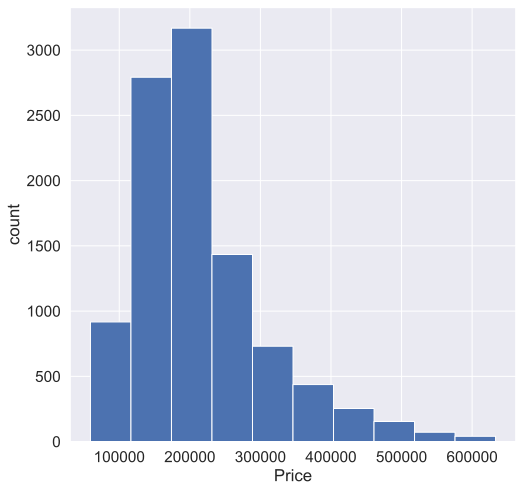

In [859]:
plt.figure(figsize = (8, 8))
mos['Price'].hist(density=False, bins=10)
plt.ylabel('count')
plt.xlabel('Price')

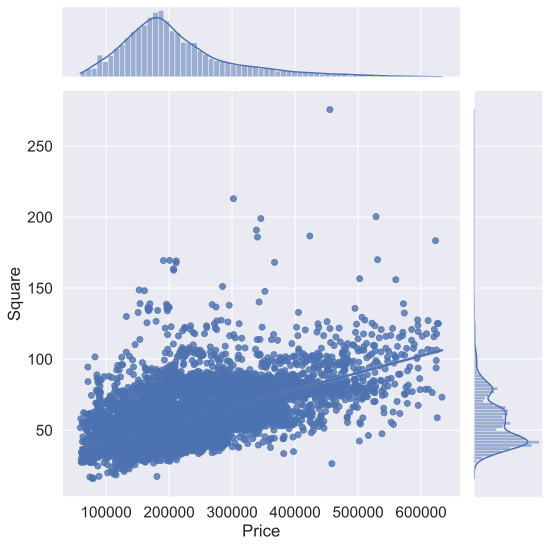

In [858]:
grid = sns.jointplot(mos['Price'], mos['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

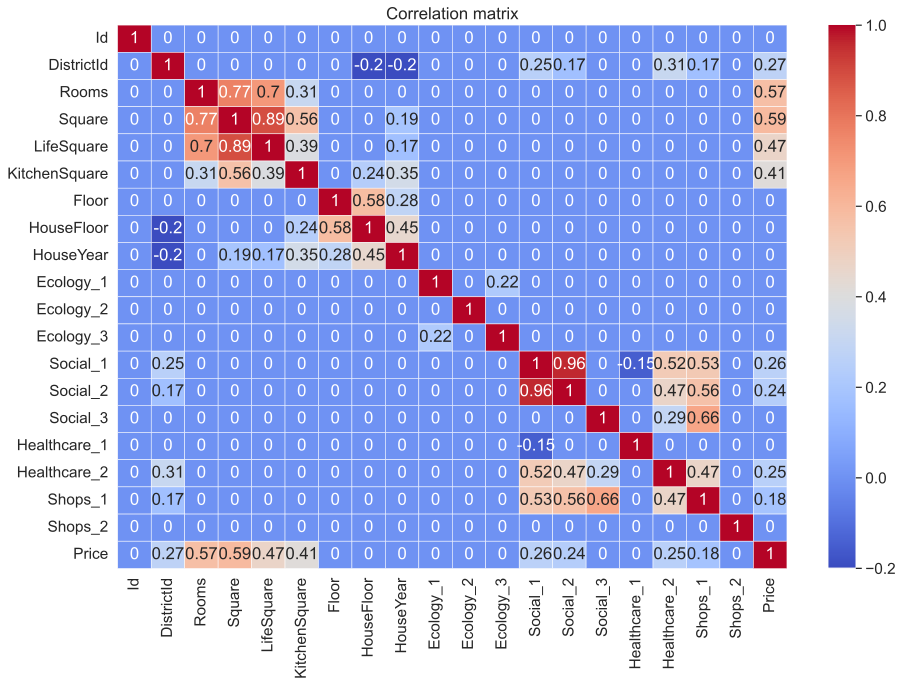

In [860]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = mos.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.15] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Столбец 'Id' интереса для построения модели не представляет, отбросим его.

In [427]:
X = mos.copy()
X.describe()

Id    DistrictId         Rooms        Square    LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    8383.40770     50.400800      1.888800     56.182619     36.618252   
std     4859.01902     43.587592      0.812589     18.946465     14.675769   
min        0.00000      0.000000      1.000000     13.784865      8.822988   
25%     4169.50000     20.000000      1.000000     41.784790     26.034847   
50%     8394.50000     36.000000      2.000000     52.539909     33.452635   
75%    12592.50000     75.000000      2.000000     65.889736     44.404930   
max    16798.00000    209.000000      5.000000    275.645284    233.949309   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  1.000000e+04   
mean        7.811859      8.526700     13.618200   1984.863800  1.264915e-01   
std         2.492094      5.241148      6.024306     18.409979  1.173824e-01   
min         4.000000      1.000000      1.000000   1910.000000  1.800000e-09   
25%         6.000000      4.000000      9.000000   1974.000000  3.465608e-02   
50%         7.859210      7.000000     14.000000   1977.000000  8.688527e-02   
75%         9.000000     12.000000     17.000000   2001.000000  2.001468e-01   
max        43.000000     42.000000    117.000000   2020.000000  5.218671e-01   

       ...     Ecology_3      Social_1      Social_2      Social_3  \
count  ...  10000.000000  10000.000000  10000.000000  10000.000000   
mean   ...      0.027500     24.687000   5352.157400      8.039200   
std    ...      0.163543     17.532614   4006.799803     23.831875   
min    ...      0.000000      0.000000    168.000000      0.000000   
25%    ...      0.000000      6.000000   1564.000000      0.000000   
50%    ...      0.000000     25.000000   5285.000000      2.000000   
75%    ...      0.000000     36.000000   7227.000000      5.000000   
max    ...      1.000000     74.000000  19083.000000    141.000000   

       Healthcare_1  Healthcare_2       Shops_1       Shops_2          Price  \
count  10000.000000  10000.000000  10000.000000  10000.000000   10000.000000   
mean    1265.353852      1.319500      4.231300      0.082500  214138.857399   
std     1287.997747      1.493601      4.806341      0.275139   92872.293865   
min        3.516484      0.000000      0.000000      0.000000   59174.778028   
25%      229.000000      0.000000      1.000000      0.000000  153872.633942   
50%      750.000000      1.000000      3.000000      0.000000  192269.644879   
75%     2035.525641      2.000000      6.000000      0.000000  249135.462171   
max     4849.000000      6.000000     23.000000      1.000000  633233.466570   

          TruePrice  
count  10000.000000  
mean    3927.821533  
std      997.087952  
min     2280.972900  
25%     2938.048340  
50%     4134.353516  
75%     4562.026367  
max     8700.768555  

[8 rows x 21 columns]

In [428]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int8   
 11  Ecology_3      10000 non-null  int8   
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Healthcare_2   10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [430]:
X.drop(['Id', 'Price'], axis=1, inplace=True)
colnames = X.columns

In [99]:
colnames

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Healthcare_2',
       'Shops_1', 'Shops_2', 'AverageDP'],
      dtype='object')

DistrictId        Rooms       Square   LifeSquare  KitchenSquare  \
count  9694.000000  9694.000000  9694.000000  9694.000000    9694.000000   
mean     50.158758     1.880029    55.816081    36.380013       7.768137   
std      43.342966     0.801672    18.151444    14.324529       2.426921   
min       0.000000     1.000000    17.414181    10.651455       4.000000   
25%      18.000000     1.000000    41.844030    26.031966       6.000000   
50%      36.000000     2.000000    52.405784    33.368159       7.823877   
75%      75.000000     2.000000    65.578720    44.070625       9.000000   
max     209.000000     5.000000   275.645284   233.949309      43.000000   

             Floor   HouseFloor    HouseYear     Ecology_1    Ecology_2  \
count  9694.000000  9694.000000  9694.000000  9.694000e+03  9694.000000   
mean      8.546111    13.629358  1984.695482  1.276589e-01     0.010006   
std       5.241913     5.994059    18.210387  1.178289e-01     0.099534   
min       1.000000     1.000000  1910.000000  1.800000e-09     0.000000   
25%       4.000000     9.000000  1974.000000  3.465608e-02     0.000000   
50%       7.000000    14.000000  1977.000000  8.729039e-02     0.000000   
75%      12.000000    17.000000  2000.000000  2.114012e-01     0.000000   
max      42.000000   117.000000  2020.000000  5.218671e-01     1.000000   

         Ecology_3     Social_1      Social_2     Social_3  Healthcare_1  \
count  9694.000000  9694.000000   9694.000000  9694.000000   9694.000000   
mean      0.027749    24.848772   5385.997318     7.790798   1120.384049   
std       0.164262    17.542221   4013.927450    23.363273   1182.097143   
min       0.000000     0.000000    168.000000     0.000000      3.516484   
25%       0.000000     6.000000   1564.000000     0.000000    203.208511   
50%       0.000000    25.000000   5285.000000     2.000000    645.000000   
75%       0.000000    36.000000   7287.000000     4.000000   1575.000000   
max       1.000000    74.000000  19083.000000   141.000000   4849.000000   

       Healthcare_2      Shops_1      Shops_2  
count   9694.000000  9694.000000  9694.000000  
mean       1.316175     4.234475     0.084279  
std        1.484120     4.785010     0.277820  
min        0.000000     0.000000     0.000000  
25%        0.000000     1.000000     0.000000  
50%        1.000000     3.000000     0.000000  
75%        2.000000     6.000000     0.000000  
max        6.000000    23.000000     1.000000

## Построение модели.

In [274]:
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X), columns=colnames)

In [431]:
scaler = RobustScaler()
X_train = pd.DataFrame(scaler.fit_transform(X), columns=colnames)

In [379]:
# scaler = MinMaxScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X), columns=colnames)

In [432]:
X_train.describe()

DistrictId         Rooms        Square    LifeSquare  KitchenSquare  \
count  10000.000000  10000.000000  1.000000e+04  10000.000000   10000.000000   
mean       0.261833     -0.111200  1.511188e-01      0.172325      -0.015784   
std        0.792502      0.812589  7.859991e-01      0.798895       0.830698   
min       -0.654545     -1.000000 -1.607763e+00     -1.340748      -1.286403   
25%       -0.290909     -1.000000 -4.461789e-01     -0.403797      -0.619737   
50%        0.000000      0.000000  1.473854e-16      0.000000       0.000000   
75%        0.709091      0.000000  5.538211e-01      0.596203       0.380263   
max        3.145455      3.000000  9.255585e+00     10.914304      11.713597   

              Floor    HouseFloor     HouseYear     Ecology_1     Ecology_2  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.190837     -0.047725      0.291252      0.239326      0.009700   
std        0.655144      0.753038      0.681851      0.709299      0.098015   
min       -0.750000     -1.625000     -2.481481     -0.525016      0.000000   
25%       -0.375000     -0.625000     -0.111111     -0.315602      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.625000      0.375000      0.888889      0.684398      0.000000   
max        4.375000     12.875000      1.592593      2.628436      1.000000   

          Ecology_3      Social_1      Social_2      Social_3  Healthcare_1  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.027500     -0.010433      0.011859      1.207840      0.285273   
std        0.163543      0.584420      0.707540      4.766375      0.712970   
min        0.000000     -0.833333     -0.903585     -0.400000     -0.413215   
25%        0.000000     -0.633333     -0.657072     -0.400000     -0.288399   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.366667      0.342928      0.600000      0.711601   
max        1.000000      1.633333      2.436518     27.800000      2.268996   

       Healthcare_2       Shops_1       Shops_2     TruePrice  
count   10000.00000  10000.000000  10000.000000  10000.000000  
mean        0.15975      0.246260      0.082500     -0.127170  
std         0.74680      0.961268      0.275139      0.613976  
min        -0.50000     -0.600000      0.000000     -1.141260  
25%        -0.50000     -0.400000      0.000000     -0.736651  
50%         0.00000      0.000000      0.000000      0.000000  
75%         0.50000      0.600000      0.000000      0.263349  
max         2.50000      4.000000      1.000000      2.811870

Стандартизируем данные и используем TSNE для визуализации наших данных.

In [434]:
dim_reducer = TSNE(n_components=2, learning_rate=500, random_state=55, perplexity=60, n_jobs=-1, early_exaggeration=25)
components = dim_reducer.fit_transform(X_train)
colnamess = ['component_' + str(i) for i in range(1, 3)]
components_3d = pd.DataFrame(data = components, columns = colnamess) 

In [435]:
components_3d.head()

component_1  component_2
0   -13.015891   -47.578819
1    25.084805    -3.116587
2   -10.050775    -0.894786
3   -94.552872   -17.007576
4   -15.623705    29.243444

In [523]:
display_components_in_2D_space(components_3d, y)

Попробуем кластеризовать наши данные.

In [436]:
kmeans_8 = KMeans(n_clusters=8, random_state=55)
labels_clast_8 = kmeans_8.fit_predict(X_train)
# labels_clast_8 = kmeans_8.fit_predict(components_3d)
labels_clast_8 = pd.Series(labels_clast_8, name='clusters_8')

In [409]:
dbscan = DBSCAN(eps=0.5, min_samples=15)
labels_clast = dbscan.fit_predict(X_train)
labels_clast = pd.Series(labels_clast, name='clusters_dbscan')

In [437]:
aggl = AgglomerativeClustering(n_clusters=15)
labels_clast = aggl.fit_predict(X_train)
labels_clast = pd.Series(labels_clast, name='clusters_aggl')


In [499]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, cluster_h)
labels_clast = knn.predict(X_train)

# labels_clast_test = knn.predict(X_test)

In [436]:
inertias = []

for i in range(3, 20):
    temp_model = AgglomerativeClustering(n_clusters=12)
    temp_model.fit(X_train)
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)

plt.plot(range(3, 20), inertias)

plt.title('Inertia')

plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'inertia_'

In [525]:
display_components_in_2D_space(components_3d, labels_clast_8)

In [437]:
clust_8 = pd.DataFrame({'Cluster': labels_clast_8})
clust_8

Cluster
0           7
1           4
2           7
3           0
4           2
...       ...
9995        4
9996        0
9997        6
9998        4
9999        4

[10000 rows x 1 columns]

Попробуем использовать данные о кластеризации.

In [964]:
clusters_8_dummies = pd.get_dummies(labels_clast_8, prefix='clusters_8')
X_train_cluster = pd.concat([X_train, components_3d, clusters_8_dummies], axis=1)
X_train_cluster.head()

DistrictId     Rooms    Square  LifeSquare  KitchenSquare     Floor  \
0   -0.536895  1.367550  3.106448    2.611604       1.016986 -0.863728   
1   -0.651613 -1.093843 -0.863175   -0.916728       0.239660 -0.291306   
2   -1.133425  1.367550  1.169798    0.753031       1.016986 -1.245343   
3   -1.133425 -1.093843 -0.832694   -0.701412      -1.299061  0.281117   
4    1.000316  0.136853  0.427704    0.132260       0.628323  1.425961   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  ...  component_2  component_3  \
0   -0.563811   1.582710  -0.435077   -0.09897  ...     2.385016   -12.915560   
1   -0.892019  -1.024702  -0.067766   -0.09897  ...    10.809358     5.348845   
2    0.584915   0.170362  -0.859476   -0.09897  ...     2.378371     3.086715   
3    1.405433  -0.427170  -1.016976   -0.09897  ...    26.343052    -1.967870   
4    0.420811  -0.698776   1.331664   -0.09897  ...    -3.876667    -7.307023   

   clusters_8_0  clusters_8_1  clusters_8_2  clusters_8_3  clusters_8_4  \
0             0             0             0             1             0   
1             0             0             0             0             0   
2             0             0             0             1             0   
3             0             0             0             0             1   
4             0             0             0             0             0   

   clusters_8_5  clusters_8_6  clusters_8_7  
0             0             0             0  
1             0             1             0  
2             0             0             0  
3             0             0             0  
4             1             0             0  

[5 rows x 29 columns]

In [438]:
# X_train_c = pd.concat([X, labels_clast, components_3d], axis=1)
X_train_c = pd.concat([X, clust_8, components_3d], axis=1)
X_train_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     10000 non-null  float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  int8   
 10  Ecology_3      10000 non-null  int8   
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   10000 non-null  float64
 15  Healthcare_2   10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  int8   
 18  TruePri

In [184]:
from sklearn.model_selection import GridSearchCV

In [116]:
help(RandomForestRegressor)

Help on class RandomForestRegressor in module sklearn.ensemble._forest:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest regressor.
 |  
 |  A random forest is a meta estimator that fits a number of classifying
 |  decision trees on various sub-samples of the dataset and uses averaging
 |  to improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimato

In [439]:
X.head()

DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0          27    3.0  115.027311   74.945448      10.000000      4   
1          22    1.0   39.832524   23.169223       8.000000      7   
2           1    3.0   78.342215   47.671972      10.000000      2   
3           1    1.0   40.409907   26.328866       4.849189     10   
4          94    2.0   64.285067   38.562517       9.000000     16   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424          0          0        11      3097   
1         8.0       1966   0.118537          0          0        30      6207   
2        17.0       1988   0.025609          0          0        33      5261   
3        22.0       1977   0.007122          0          0         1       264   
4        16.0       1972   0.282798          0          0        33      8667   

   Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2    TruePrice  
0         0   3125.000000             0        0        0  2759.086182  
1         1   1183.000000             1        0        0  3553.678467  
2         0    240.000000             3        1        0  3251.202393  
3         0     21.967871             0        1        0  3251.202393  
4         2   1041.000000             0        6        0  4219.992676

In [440]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=5, # минимальное кол-во наблюдений в листе дерева
                                 random_state=55,
                                 n_estimators=300,  # кол-во деревьев
                                 max_features=7, 
                                 min_samples_split=5
                                 )
rf_model.fit(X_train_c, y)

RandomForestRegressor(criterion='mse', max_depth=20, max_features=7,
                      min_samples_leaf=5, min_samples_split=5, n_estimators=300,
                      random_state=55)

In [441]:
fi = pd.DataFrame({'feature': list(X_train_c.columns),
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head(20)

feature  importance
2          Square    0.241948
18      TruePrice    0.199368
3      LifeSquare    0.102678
1           Rooms    0.101557
20    component_1    0.055860
19        Cluster    0.044556
12       Social_2    0.037960
11       Social_1    0.036521
4   KitchenSquare    0.035506
21    component_2    0.025081
13       Social_3    0.020895
7       HouseYear    0.018720
0      DistrictId    0.014887
6      HouseFloor    0.013901
8       Ecology_1    0.011926
14   Healthcare_1    0.011411
5           Floor    0.011110
16        Shops_1    0.009041
15   Healthcare_2    0.006495
17        Shops_2    0.000428

In [343]:
estimator = RandomForestRegressor()
param_grid = { 
            "criterion" : ["squared_error"],
            "n_estimators"      : [200, 300],
            "max_features"      : [6, 7],
            "min_samples_split" : [5],
            "bootstrap": [True],
            "min_samples_leaf" : [5],
            "max_depth" : [20],
            'n_jobs' : [-1],
            'random_state' : [55]
                        }
grid = GridSearchCV(estimator, param_grid, cv=5)
grid.fit(X_train_c, y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'criterion': ['squared_error'],
                         'max_depth': [20], 'max_features': [6, 7],
                         'min_samples_leaf': [5], 'min_samples_split': [5],
                         'n_estimators': [200, 300], 'n_jobs': [-1],
                         'random_state': [55]})

In [344]:
cv_results = pd.DataFrame(grid.cv_results_)

cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_bootstrap', 'param_criterion', 'param_max_depth',
       'param_max_features', 'param_min_samples_leaf',
       'param_min_samples_split', 'param_n_estimators', 'param_n_jobs',
       'param_random_state', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

In [345]:
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score', 'rank_test_score', 'split1_test_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

param_bootstrap param_criterion param_max_depth param_max_features  \
3            True   squared_error              20                  7   
2            True   squared_error              20                  7   
1            True   squared_error              20                  6   
0            True   squared_error              20                  6   

  param_min_samples_leaf param_min_samples_split param_n_estimators  \
3                      5                       5                300   
2                      5                       5                200   
1                      5                       5                300   
0                      5                       5                200   

  param_n_jobs param_random_state  mean_test_score  rank_test_score  \
3           -1                 55         0.723979                1   
2           -1                 55         0.723874                2   
1           -1                 55         0.723505                3   
0           -1                 55         0.723078                4   

   split1_test_score  
3           0.733448  
2           0.733905  
1           0.732336  
0           0.731904

In [442]:
y_pred = rf_model.predict(X_train_c)

In [96]:
y_p = pd.DataFrame({'Price_p': y_pred})
y_p

Price_p
0     279406.185922
1     172218.435517
2     256874.742629
3     151819.580195
4     286523.213561
...             ...
9995  205978.831900
9996  197927.458620
9997  159257.659164
9998  152799.699376
9999  160513.326326

[10000 rows x 1 columns]

In [443]:
accuracy(y, y_pred)

R2:	0.8723
RMSE:	33180.9203
MSE:	1100973471.4127


In [467]:
test_s = test.copy()
test_s.drop('Id', axis=1, inplace=True)
colnames = test_s.columns

In [468]:
test_scaler = pd.DataFrame(scaler.fit_transform(test_s), columns=colnames)
# test_scaler.drop(['Id'], axis=1, inplace=True)

In [464]:
test_scaler.tail()

DistrictId  Rooms    Square  LifeSquare  KitchenSquare  Floor  \
4995   -0.142857    0.0 -0.401436   -0.185908      -0.927306 -0.125   
4996    0.017857    1.0  1.672214    1.465999       0.739360  1.750   
4997    1.142857   -1.0 -0.792223   -0.795743      -0.927306 -0.625   
4998   -0.482143   -1.0 -0.587880   -0.689610       0.406027  0.125   
4999   -0.285714    0.0  0.581410    0.007983       1.739360  0.250   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  Ecology_3  Social_1  \
4995      -0.875  -0.555556  -0.097456        0.0        0.0  0.200000   
4996       1.625   1.518519  -0.147853        0.0        0.0 -0.333333   
4997      -1.125  -0.407407  -0.272665        0.0        0.0  0.100000   
4998       0.000  -0.259259   0.012190        0.0        0.0  0.266667   
4999       0.375   1.185185   0.608809        0.0        0.0  0.733333   

      Social_2  Social_3  Healthcare_1  Healthcare_2  Shops_1  Shops_2  \
4995  0.145728       0.4     -0.115657           0.0     -0.2      0.0   
4996 -0.436484       0.0     -0.120373          -0.5      0.8      0.0   
4997  0.218067      -0.2      0.163364           0.5      0.4      0.0   
4998  0.470208       0.6      1.822224          -0.5      1.6      0.0   
4999  0.475100       0.2     -0.346790           1.0      0.4      0.0   

      TruePrice  
4995   0.017558  
4996   0.312881  
4997   0.018639  
4998   0.185428  
4999  -0.105828

In [465]:
dim_reducer = TSNE(n_components=2, learning_rate=500, random_state=55, perplexity=60, n_jobs=-1, early_exaggeration=25)
components = dim_reducer.fit_transform(test_scaler)
colnamess = ['component_' + str(i) for i in range(1, 3)]
components_2d = pd.DataFrame(data = components, columns = colnamess) 

In [466]:
kmeans_8 = KMeans(n_clusters=8, random_state=55)
labels_clast_8 = kmeans_8.fit_predict(test_scaler)
# labels_clast_8 = pd.Series(labels_clast_8, name='clusters_8')
clust_8 = pd.DataFrame({'Cluster': labels_clast_8})
clust_8

Cluster
0           1
1           4
2           4
3           4
4           1
...       ...
4995        1
4996        3
4997        1
4998        1
4999        6

[5000 rows x 1 columns]

In [469]:
test_c = pd.concat([test_s, clust_8, components_2d], axis=1)
# test_c.drop(['Id'], axis=1, inplace=True)
test_c.head()

DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  \
0          44    1.0  36.847630   19.094182       5.000000      5         9.0   
1          62    1.0  42.493907   27.686685      10.000000      7        17.0   
2          27    2.0  59.463678   38.743252       9.000000     19        19.0   
3          23    3.0  49.646030   33.893825       6.000000      2         2.0   
4          74    1.0  53.837056   35.077255       6.460447      8        17.0   

   HouseYear  Ecology_1  Ecology_2  ...  Social_2  Social_3  Healthcare_1  \
0       1970   0.036122          0  ...      4378         0    1036.00000   
1       2017   0.072158          0  ...       629         1      81.02981   
2       1977   0.211401          0  ...      1892         0    3125.00000   
3       1965   0.014073          0  ...       475         0     537.00000   
4       1977   0.309479          0  ...      7715         4     990.00000   

   Healthcare_2  Shops_1  Shops_2    TruePrice  Cluster  component_1  \
0             1        1        0  4610.399414        1    -6.790039   
1             0        0        1  2613.223633        4   -27.023548   
2             0        1        0  2759.086182        4   -55.743225   
3             0        0        0  2280.972900        4   -25.539881   
4             0        6        0  3319.317871        1   -21.533115   

   component_2  
0    22.999811  
1   -39.163635  
2   -20.490414  
3   -59.261974  
4     2.518436  

[5 rows x 22 columns]

In [897]:
clusters_8_dummies = pd.get_dummies(labels_clast_8, prefix='clusters_8')
test_cluster = pd.concat([test_scaler, components_3d, clusters_8_dummies], axis=1)
test_cluster.head()

DistrictId     Rooms    Square  LifeSquare  KitchenSquare     Floor  \
0   -0.164781 -1.122498 -1.037541   -1.234510      -0.917578 -0.662450   
1    0.242689 -1.122498 -0.739300   -0.634793       1.026394 -0.297665   
2   -0.549613  0.113733  0.157058    0.136904       0.637600  1.891046   
3   -0.640162  1.349964 -0.361519   -0.201564      -0.528784 -1.209627   
4    0.514336 -1.122498 -0.140145   -0.118966      -0.768395 -0.115272   

   HouseFloor  HouseYear  Ecology_1  Ecology_2  ...  component_2  component_3  \
0   -0.705308  -0.774992  -0.775941  -0.098453  ...     5.443538     3.301305   
1    0.578529   1.755796  -0.471528  -0.098453  ...     3.605369     8.041227   
2    0.899488  -0.398066   0.704754  -0.098453  ...    -3.151659    -6.067861   
3   -1.828665  -1.044225  -0.962206  -0.098453  ...   -11.713637    -5.786822   
4    0.578529  -0.398066   1.533281  -0.098453  ...    15.871234     1.143071   

   clusters_8_0  clusters_8_1  clusters_8_2  clusters_8_3  clusters_8_4  \
0             0             1             0             0             0   
1             1             0             0             0             0   
2             0             0             0             1             0   
3             0             0             0             1             0   
4             0             1             0             0             0   

   clusters_8_5  clusters_8_6  clusters_8_7  
0             0             0             0  
1             0             0             0  
2             0             0             0  
3             0             0             0  
4             0             0             0  

[5 rows x 29 columns]

In [470]:
y_pred = rf_model.predict(test_c)

In [471]:
My_pred = pd.DataFrame({'Id': test['Id'], 'Price': y_pred})
My_pred.to_csv("ABorisenko_predictions.csv", sep=",", index=False)
My_pred

Id          Price
0      4567  169219.352284
1      5925  127695.167242
2       960  159237.969947
3      3848  139834.290968
4       746  182078.457325
...     ...            ...
4995  10379  176348.446490
4996  16138  400441.109935
4997   3912  146288.520739
4998   5722  189665.782133
4999  11004  264624.204519

[5000 rows x 2 columns]

In [475]:
My_pred1 = pd.read_csv("ABorisenko_predictions_old.csv", sep=",")
My_pred1

Id          Price
0      4567  163109.441208
1      5925  119764.355480
2       960  137914.826531
3      3848  128187.232211
4       746  205579.510158
...     ...            ...
4995  10379  189796.476683
4996  16138  395155.502010
4997   3912  153219.049987
4998   5722  197055.474471
4999  11004  304281.263496

[5000 rows x 2 columns]